# Narrative Miners: Uncover the Stories That Drive Markets

## Automated Analysis of Market Narratives Across Multiple Document Sources

## Why It Matters

Understanding how market narratives emerge and evolve across different information sources is crucial for investment decision-making, but manually tracking narrative development across scattered news coverage, earnings calls, and regulatory filings is time consuming. Investment decisions need systematic analysis of narrative progression to identify emerging trends and timing patterns.

## What It Does

The `NarrativeMiner` class in the bigdata-research-tools package systematically tracks narrative evolution across multiple document types using unstructured data from news, transcripts, and filings. Built for analysts, portfolio managers, and investment professionals, it transforms scattered narrative signals into quantified trend intelligence and identifies timing patterns across different information sources.

## How It Works

The `NarrativeMiner` combines **multi-source content retrieval**, **temporal narrative tracking**, and **cross-source comparative analysis** to deliver:

- **Cross-document narrative mapping** across news media, earnings calls, and SEC filings
- **Temporal evolution tracking** showing how narratives develop and change over time across sources
- **Intensity measurement** quantifying narrative prevalence and significance across document types

## A Real-World Use Case

This cookbook demonstrates the complete workflow through analyzing "AI Bubble Concerns" narrative as it emerges and evolves across news, earnings calls, and regulatory filings, highlighting the difference between public discourse and corporate communications.

## Setup and Imports

## Async Compatibility Setup

**Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

### Why is this needed?

Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When bigdata-research-tools makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

The `nest_asyncio.apply()` command patches this to allow nested event loops.

💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [1]:
import datetime
start = datetime.datetime.now()

try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed or not available")

✅ nest_asyncio applied


## Environment Setup

The following cell configures the necessary path for the analysis

In [2]:
import os
import sys

current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries

Import the core libraries needed for narrative mining analysis, including the custom visualization and analysis tools.

In [3]:
from IPython.display import display, HTML, IFrame
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings

from src.tool import (
    load_results, 
    extract_narrative_insights,
    create_source_summary,
    display_sample_data,
    visualize_cross_source_narratives, 
    visualize_news_narrative_breakdown
)

from bigdata_research_tools.workflows.narrative_miner import NarrativeMiner
from bigdata_research_tools.excel import ExcelManager
from bigdata_client import Bigdata
from bigdata_client.daterange import RollingDateRange
from bigdata_client.models.sources import Source
from bigdata_client.models.search import DocumentType

## Optional: Plotly Display Configuration

For better visualization rendering, you can also set the Plotly renderer:

In [4]:
import plotly
import plotly.graph_objects as go
import plotly.io as pio

# Try to detect the environment and set appropriate renderer
try:
    # Check if we're in JupyterLab
    import os
    if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ or 'JPY_SESSION_NAME' in os.environ:
        pio.renderers.default = 'jupyterlab'
        print("✅ Plotly configured for JupyterLab")
    else:
        # Default for VS Code, Jupyter Notebook, etc.
        pio.renderers.default = 'plotly_mimetype+notebook'
        print("✅ Plotly configured for Jupyter/VS Code")
except:
    # Fallback to a more universal renderer
    pio.renderers.default = 'notebook'
    print("✅ Plotly configured with fallback renderer")



✅ Plotly configured for Jupyter/VS Code


## Define Output Paths

We define the output paths for our narrative mining results.

In [5]:
# Define output file paths for our results
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

news_results_path = f"{output_dir}/ai_bubble_news.xlsx"
transcripts_results_path = f"{output_dir}/ai_bubble_transcripts.xlsx"
filings_results_path = f"{output_dir}/ai_bubble_filings.xlsx"
visualization_path = f"{output_dir}/ai_bubble_narratives.html"

## Load Credentials

In [6]:
from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [7]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

## Defining the Narrative Analysis Parameters

### Fixed Parameters
- **AI Bubble Narratives** (`main_narratives`): Specific narrative sentences related to AI bubble concerns
- **Common Parameters** (`common_params`): Shared configuration across all narrative miners
- **Model Selection** (`llm_model`): The LLM model used for narrative labeling and analysis
- **Time Period** (`start_date` and `end_date`): The date range over which to run the analysis
- **Rerank Threshold** (`rerank_threshold`): Cross-encoder threshold for result relevance filtering
- **Document Limits** (`document_limit`): Maximum number of documents to retrieve per query
- **Search Frequency** (`freq`): Frequency of date ranges for search operations

In [8]:
# AI Bubble Narratives
main_narratives = [
    "Tech valuations have detached from fundamental earnings potential",
    "AI investments show classic signs of irrational exuberance",
    "Market is positioning AI as revolutionary without proven ROI",
    "Current AI investments may not generate predicted financial returns",
    "Tech CEOs acknowledge AI implementation challenges amid high expectations",
    "Analysts are questioning the timeline for AI-driven profits",
    "Companies are spending billions on unproven AI technology",
    "AI infrastructure costs are rising but revenue gains remain uncertain",
    "Venture capital is flooding AI startups at unsustainable valuations",
    "Regulatory concerns could derail AI market growth projections",
    "Public discourse about AI capabilities exceeds technical realities",
    "AI talent acquisition costs have created an unsustainable bubble",
    "Corporate executives privately express concerns about AI ROI timelines",
    "AI market projections rely on aggressive and unproven assumptions",
    "Industry veterans drawing parallels to previous tech bubbles"
]

# LLM Specification
llm_model = "openai::gpt-4o-mini"


# Specify Time Range
start_date = "2024-03-01"
end_date = "2025-03-28"

# Rerank Threshold
rerank_threshold = 0.7

# Search Frequency
freq = '6M'

# Fiscal Year
fiscal_year = 2024

# Document Limits
document_limit = 10

# Commen Params
common_params = {
    "narrative_sentences": main_narratives,
    "llm_model": llm_model,
    "start_date": start_date,
    "end_date": end_date,
    "rerank_threshold": rerank_threshold}

## Configure the Narrative Miners

Create narrative miners for each document type. In this example, we select MT Newswires as the news source.

In [9]:
# Common Params
common_params = {
    "narrative_sentences": main_narratives,
    "llm_model": llm_model,
    "start_date": start_date,
    "end_date": end_date,
    "rerank_threshold": rerank_threshold}
    
# Choose MT Newswires as a news source
tech_news_sources = bigdata.knowledge_graph.find_sources("MT Newswires")
tech_news_ids = [source.id for source in tech_news_sources if "MT Newswires" == source.name]

# Create the specialized miners for each document type
news_miner = NarrativeMiner(
    sources=tech_news_ids,
    document_type=DocumentType.NEWS,
    fiscal_year=None,
    **common_params
)

transcripts_miner = NarrativeMiner(
    sources=None,
    document_type=DocumentType.TRANSCRIPTS,
    fiscal_year=fiscal_year,
    **common_params
)

filings_miner = NarrativeMiner(
    sources=None,
    fiscal_year=fiscal_year,
    document_type=DocumentType.FILINGS,
    **common_params
)

## Run Narrative Mining Across Sources

Execute the narrative mining processes for news, earnings call transcripts, and SEC filings:

In [10]:
# Mine news narratives
print("Mining news narratives...")
try:
    news_results = news_miner.mine_narratives(
        document_limit=document_limit,
        freq=freq,
        export_path=news_results_path
    )
    print("✅ News mining completed successfully!")
except Exception as e:
    print(f"Warning during news mining: {e}")

Mining news narratives...


Querying OpenAI...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


✅ News mining completed successfully!


In [11]:
# Mine transcripts narratives
print("Mining earnings call transcripts...")
try:
    transcripts_results = transcripts_miner.mine_narratives(
        document_limit=document_limit,
        freq=freq,
        export_path=transcripts_results_path
    )
    print("✅ Transcripts mining completed successfully!")
except Exception as e:
    print(f"Warning during transcripts mining: {e}")

Mining earnings call transcripts...


Querying OpenAI...: 100%|██████████| 28/28 [00:03<00:00,  7.49it/s]


✅ Transcripts mining completed successfully!


In [12]:
# Mine filings narratives
print("Mining SEC filings...")
try:
    filings_results = filings_miner.mine_narratives(
        document_limit=document_limit,
        freq=freq,
        export_path=filings_results_path
    )
    print("✅ Filings mining completed successfully!")
except Exception as e:
    print(f"Warning during filings mining: {e}")

Mining SEC filings...


Querying OpenAI...: 100%|██████████| 118/118 [00:10<00:00, 11.26it/s]


✅ Filings mining completed successfully!


## Load and Process Results

Load the exported Excel files, clean the data, and display a summary.

In [13]:
# Load results from all three document types with labeling
news_df = load_results(news_results_path, "News Media")
transcripts_df = load_results(transcripts_results_path, "Earnings Calls")
filings_df = load_results(filings_results_path, "SEC Filings")

# Create and display summary
source_summary = create_source_summary(news_df, transcripts_df, filings_df)
display(source_summary)

# Display sample data from each source
display_sample_data(news_df, transcripts_df, filings_df)

Loaded 115 narrative records from News Media
Loaded 352 narrative records from Earnings Calls
Loaded 2417 narrative records from SEC Filings


,Source Type,Record Count,Date Range,Unique Narratives
0,News Media,115,2024-05-30 to 2025-03-20,5
1,Earnings Calls,352,2024-04-30 to 2025-03-12,8
2,SEC Filings,2417,2024-05-01 to 2025-03-28,8



======= SAMPLE NEWS NARRATIVES =======


,Date,Headline,Label,Chunk Text
0,2024-05-30,Research Alert: CFRA Keeps Hold View On Shares...,Tech CEOs acknowledge AI implementation challe...,"Despite the profitability jump, BBY remains ca..."
1,2024-05-30,Research Alert: CFRA Keeps Hold View On Shares...,Tech CEOs acknowledge AI implementation challe...,"Despite the profitability jump, BBY remains ca..."
2,2024-05-30,Research Alert: CFRA Keeps Hold View On Shares...,Tech CEOs acknowledge AI implementation challe...,"Despite the profitability jump, BBY remains ca..."



======= SAMPLE EARNINGS CALL NARRATIVES =======


,Date,Headline,Label,Chunk Text
0,2024-04-30,DigitalBridge Group Inc: Q1 2024 Earnings Call...,Tech CEOs acknowledge AI implementation challe...,This is why you're seeing tech CEOs like Sam A...
1,2024-04-30,DigitalBridge Group Inc: Q1 2024 Earnings Call...,Tech CEOs acknowledge AI implementation challe...,This is why you're seeing tech CEOs like Sam A...
2,2024-04-30,DigitalBridge Group Inc: Q1 2024 Earnings Call...,Tech CEOs acknowledge AI implementation challe...,This is why you're seeing tech CEOs like Sam A...



======= SAMPLE SEC FILING NARRATIVES =======


,Date,Headline,Label,Chunk Text
0,2024-05-01,ADVANCED MICRO DEVICES INC files FORM 10-Q for...,Current AI investments may not generate predic...,"Moreover, our investments in new products and ..."
1,2024-05-01,ADVANCED MICRO DEVICES INC files FORM 10-Q for...,Current AI investments may not generate predic...,"Moreover, our investments in new products and ..."
2,2024-05-01,ADVANCED MICRO DEVICES INC files FORM 10-Q for...,Current AI investments may not generate predic...,"Moreover, our investments in new products and ..."


## Create Narrative Visualizations

Generate comparative visualizations showing narrative evolution across sources and detailed breakdown of news narratives.

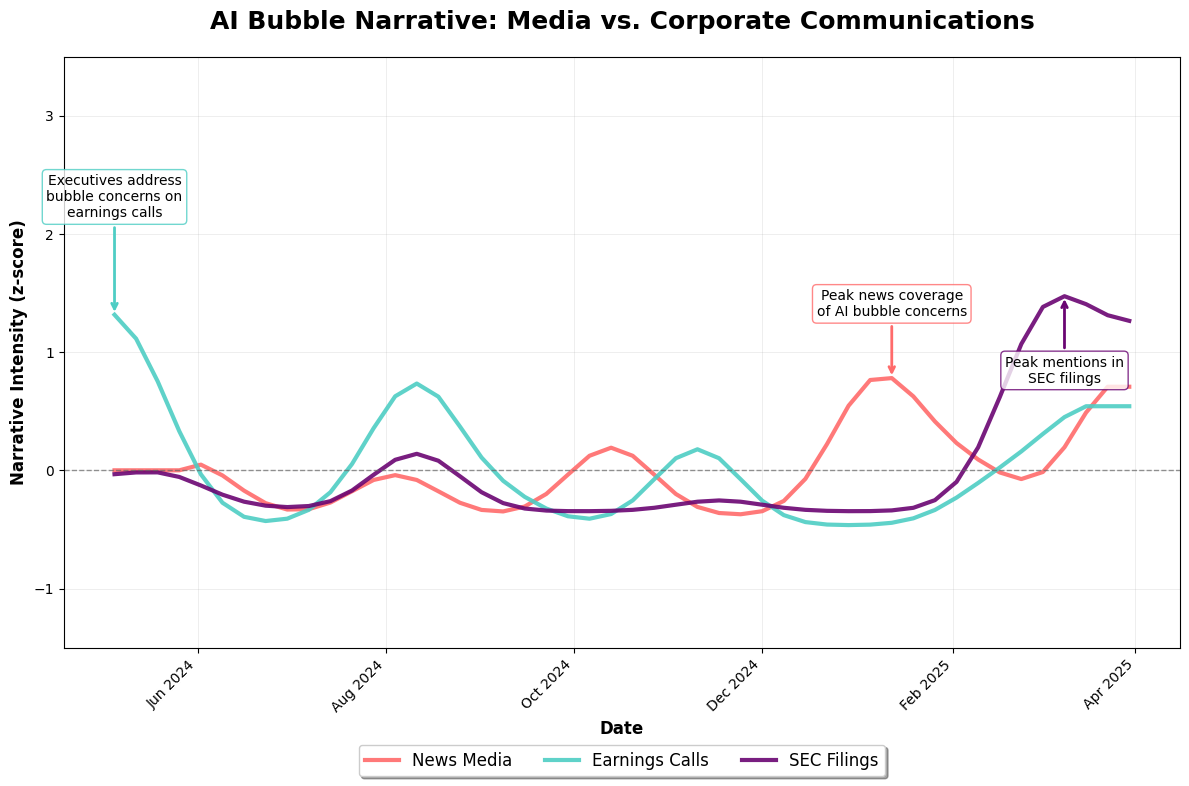

In [20]:
import warnings
warnings.filterwarnings("ignore", message=".*'method'.*", category=FutureWarning)

fig1 = visualize_cross_source_narratives(news_df, transcripts_df, filings_df, interactive=False) #set interactive=True (or False) to enable (or disable) the interactive plot
fig1.show()  

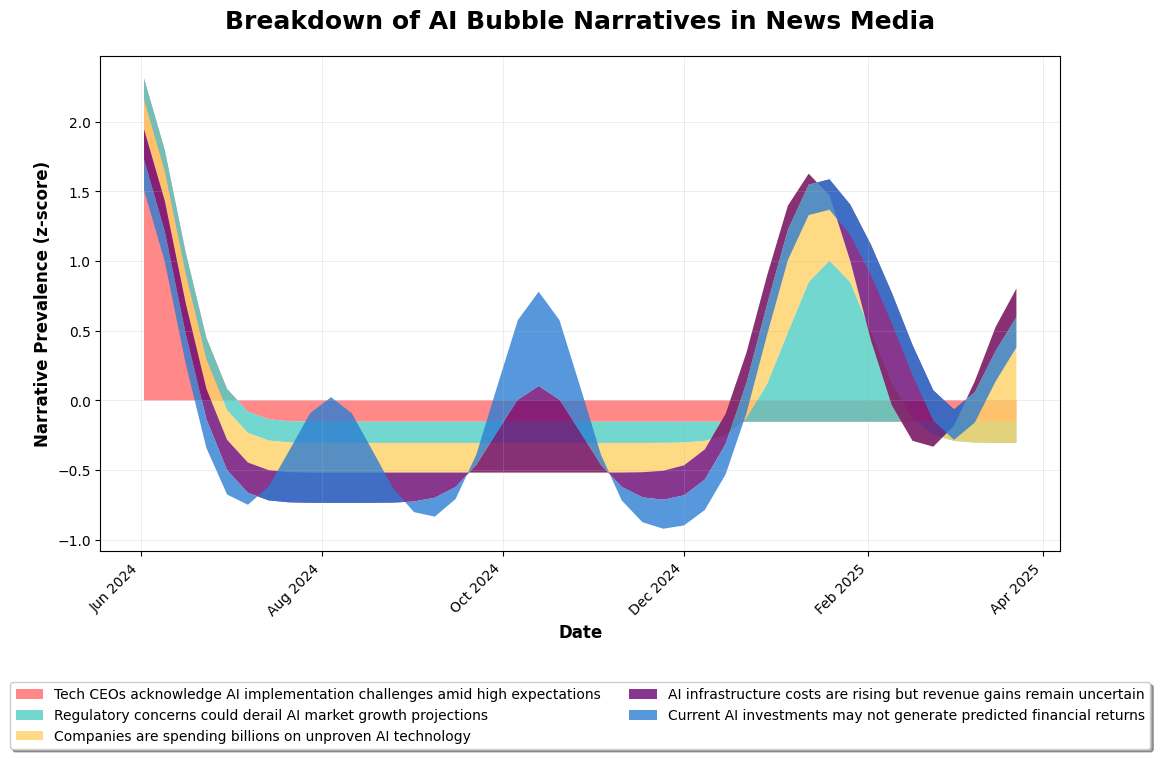

In [21]:
# Create the narrative breakdown visualization for news 
fig2 = visualize_news_narrative_breakdown(news_df, interactive=False) #set interactive=True (or False) to enable (or disable) the interactive plot
fig2.show()

## Extract and Display Key Insights

Extract key insights from the narrative mining data and display them.

In [16]:
# Extract insights from our narrative mining data
insights = extract_narrative_insights(news_df, transcripts_df, filings_df)

print("## AI Bubble Narrative Key Insights\n")
print(f"Peak month for news coverage: {insights['peak_news_month']}")
print(f"Peak month for earnings call mentions: {insights['peak_transcript_month']}")
print(f"Peak month for regulatory filing mentions: {insights['peak_filing_month']}")
print(f"\nDominant narrative in news: \"{insights['top_news_narrative']}\"")
print(f"Dominant narrative in earnings calls: \"{insights['top_transcript_narrative']}\"")
print(f"Dominant narrative in regulatory filings: \"{insights['top_filing_narrative']}\"")
print(f"\nTotal narrative mentions in news: {insights['total_news_mentions']}")
print(f"Total mentions in earnings calls: {insights['total_transcript_mentions']}")
print(f"Total mentions in regulatory filings: {insights['total_filing_mentions']}")
print(f"\nAverage lag between news coverage peaks and SEC filings: {insights['avg_lag_days']} days")

## AI Bubble Narrative Key Insights

Peak month for news coverage: January 2025
Peak month for earnings call mentions: May 2024
Peak month for regulatory filing mentions: March 2025

Dominant narrative in news: "Companies are spending billions on unproven AI technology"
Dominant narrative in earnings calls: "Tech CEOs acknowledge AI implementation challenges amid high expectations"
Dominant narrative in regulatory filings: "Current AI investments may not generate predicted financial returns"

Total narrative mentions in news: 115
Total mentions in earnings calls: 352
Total mentions in regulatory filings: 2417

Average lag between news coverage peaks and SEC filings: 32 days


## Export the Results

Export the data as Excel files for further analysis or to share with the team.

In [17]:
try:
    # Create the Excel manager
    excel_manager = ExcelManager()

    # Define the dataframes and their sheet configurations
    df_args = [
        (news_df, "News Narratives", (0, 0)),
        (transcripts_df, "Earnings Call Narratives", (0, 0)),
        (filings_df, "SEC Filing Narratives", (0, 0)),
        (source_summary, "Summary", (1, 1))
    ]

    # Save the workbook
    combined_results_path = f"{output_dir}/ai_bubble_narrative_analysis.xlsx"
    excel_manager.save_workbook(df_args, combined_results_path)
    
    print(f"✅ Results exported to {combined_results_path}")

except Exception as e:
    print(f"Warning while exporting to excel: {e}")

✅ Results exported to output/ai_bubble_narrative_analysis.xlsx


## Conclusion

The Narrative Miners reveal important patterns in how the AI bubble narrative evolved across information sources:

**Timing and Intensity Variations:**

- News media shows major spikes in AI bubble concerns, often leading the narrative cycle with the highest peaks
- Earnings calls demonstrate cyclical attention to bubble concerns, with executives addressing topics most prominently during specific quarters
- SEC filings show the most volatile pattern with multiple significant spikes, suggesting ongoing regulatory concerns

**Narrative Progression:**

- Media coverage often leads the initial bubble narrative, potentially triggering corporate responses visible in earnings calls
- Corporate executives' discussions peak during specific periods but tend to diminish over time
- SEC filing mentions frequently show increased intensity throughout the analysis period, indicating persistent regulatory attention

**Cross-Source Intelligence:**

- Different sources provide complementary perspectives on the same underlying narrative
- Timing lags between sources reveal information flow patterns and decision-making hierarchies
- The intensity patterns help identify when narratives are gaining or losing momentum across different stakeholder groups

This analysis demonstrates how systematic narrative mining across multiple document types provides richer insights than analyzing any single source in isolation.